# Tools for Thresholding Plant Data

This tutorial provides examples of functions used for thresholding gray images, and tools that can be used to resolve common issues that arise while making a binary mask. Which, if any, of these functions would be useful depends entirely on the image. Common issues, and functions that may be applicable, are contained within subsections.

# Section 1: Importing Libraries and Image

In [22]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [24]:
# Import libraries
from plantcv import plantcv as pcv 

## Input variables
The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [3]:
# Input image into self.image (include file path if image is not in 
# the same folder as jupyter notebook)

# Set self.debug to "plot" so that image outputs for each step is shown
# once cell is run in jupyter notebooks (recommended)
class options:
    def __init__(self):
        self.image = "./img/single_plant_side_view.png"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "overhead_morphology_results.txt"
        self.outdir = "."

In [ ]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

## Read the input image

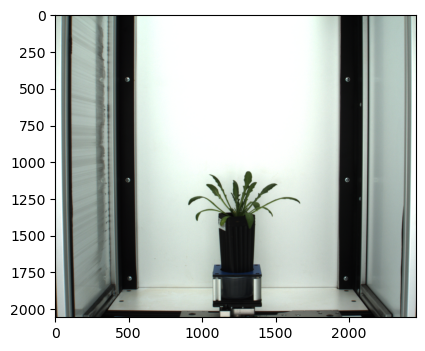

In [4]:
# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

# Section 2: Creating Basic Binary Image

* Requires successful importation of libraries and images
* Depending on the image, some simple thresholding may create a successful mask, meaning the functions included in lower 'issue' subsections will not be necessary

## Visualize colorspaces

The visualization tool converts the color image into HSV and LAB colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

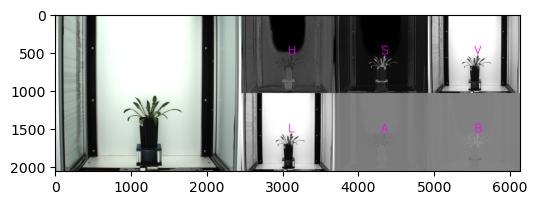

In [7]:
# Inputs:
#   rbg_img - original image
colorspaces = pcv.visualize.colorspaces(rgb_img=img)

## Convert image to gray

Identify the best channel from the colorspaces, and create a new gray image, fConverts the input color image into the HSV colorspace and returns the S (saturation) channel as a grayscale image.

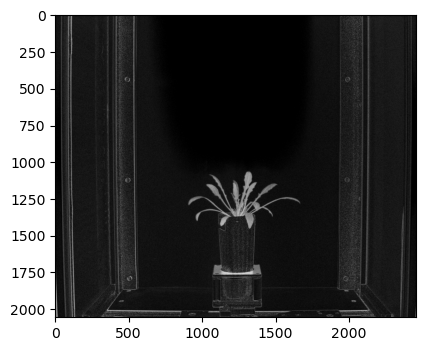

In [8]:
# Inputs:
#   rgb_img = original color image
#   channel = one of the colorspaces: 'h', 's', or 'v'
s = pcv.rgb2gray_hsv(rgb_img=img, channel="s")

## Option 1: Mean Adaptive Threshold

If an image already shows plant material that is significantly different in shade than the entire background, a mean adaptive threshold may be very useful, as it needs only the image and object type to create a binary mask. However, if there are non-plant background pixels that are a similar shade when compared to plant pixels, this threshold will not be able to differentiate.

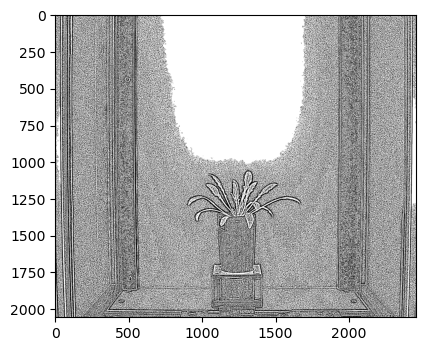

In [11]:
# Inputs:
#   gray_img    = grayscale image data
#   max_value   = value to apply above threshold (255 = white)
#   object_type = 'light' or 'dark' (default = 'light'). If object is lighter than the background then standard thresholding
#                 is done. If object is darker than the background then inverse thresholding is done.
mean_thresh = pcv.threshold.mean(gray_img = s, max_value = 255, object_type = 'light')

In this case, mean adaptive thresholding does not appear to create a useful mask. It can be more successful in images with far less background data.

## Option 2: Custom Range Threshold

Since mean adaptive thresholding was not successful for this image, another possibility is to utilize the custom range threshold to select both an upper and lower threshold for an image. The threshold can be used for gray images or RGB/HSV/LAB images, however with colored images the inputs must account for all color data, which can be difficult to estimate. For this example, we can use the gray image channel.

## Visualize the distribution of grayscale values
A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the selection of a threshold value.

For this image, the large peak between 0-70 are from the darker background pixels. The smaller peaks representing the lighter plant pixels are too difficult to see, but we can select thresholds above 70 as a starting point.

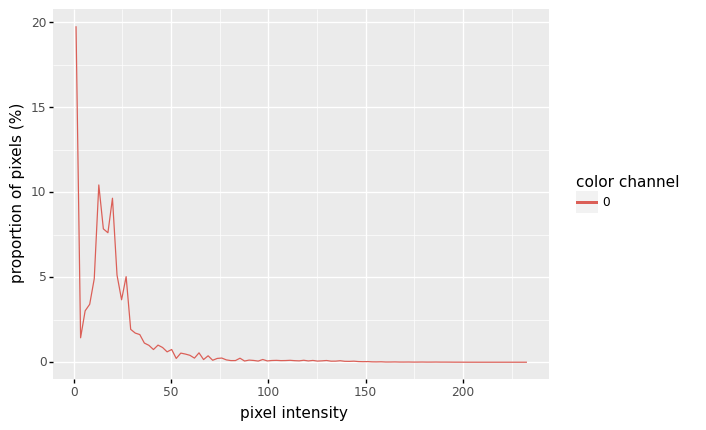

In [21]:
# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=s)

## Threshold the grayscale image

Select and upper and lower bound which includes plant material pixels, but excludes background noise, in order to create a binary mask that distinguishes between plant pixels and background.

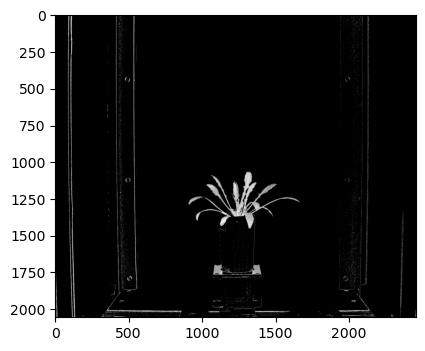

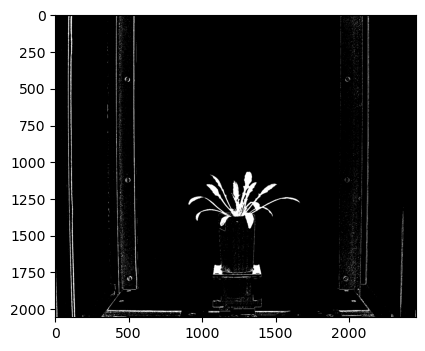

In [20]:
# Inputs:
#   img =  image data
#   lower_thresh = list of lower threshold values (0-255)
#   upper_thresh = list of upper threshold values (0-255)
#   channel = colorspace channel of interest ('RGB', 'HSV', 'LAB', or 'gray')
custom_thresh = pcv.threshold.custom_range(img = s, lower_thresh = [80], upper_thresh = [170], channel = 'gray')

This seems to create a fairly successful mask, with some background noise that can be removed using tools discussed later on in this notebook. 

## Option 3: Binary Threshold

Although the custom threshold worked well to isolate plant data, the binary threshold is another commonly-used tool for creating simple binary masks. While the custom threshold is useful especially when there is background data both darker and lighter than plant material, the binary threshold is useful because it doesn't require users to estimate the pixel shade of their plant material.

## Visualize the distribution of grayscale values
Like the previous option, a histogram can be very useful to visualize the distribution of values in an image. The histogram can aid in the selection of a threshold value.

For this image, the large peak between 0-70 are from the darker background pixels. The smaller peaks representing the lighter plant pixels are too difficult to see, but we can select thresholds above 70 as a starting point.

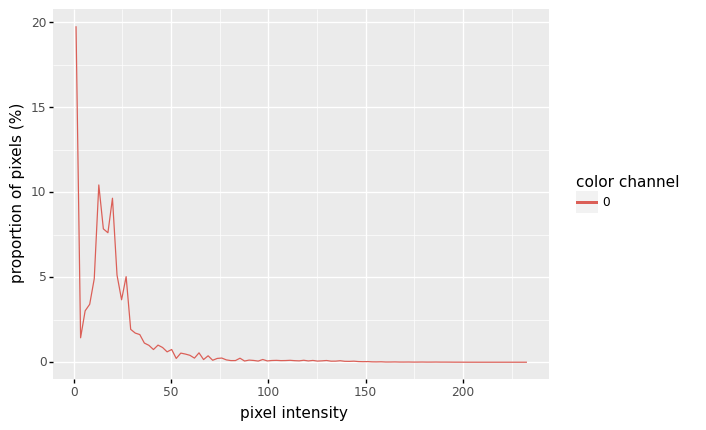

In [9]:
# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=s)

## Threshold the grayscale image¶
Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Using the histogram above, a threshold point between 80-90 will segment the plant and background peaks. Because the plant pixels are lighter compared to the background in this image, use object_type="light" to do a traditional threshold.

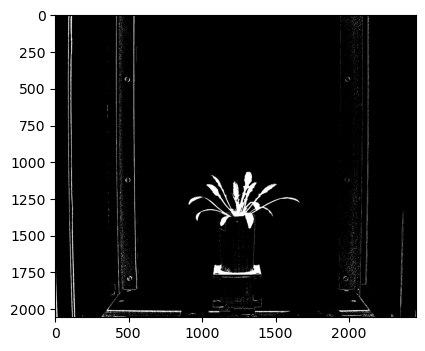

In [10]:
# Inputs:
#   gray_img    = Grayscale image data
#   threshold   = Threshold value (0-255)
#   max_value   = Value to apply above threshold (255 = white)
#   object_type = "light" or "dark" (default: "light"). If object is lighter than the background then standard 
#                 thresholding is done. If object is darker than the background then inverse thresholding is done.
s_thresh = pcv.threshold.binary(gray_img=s, threshold=84, max_value=255, object_type='light')

In some cases, one of these three options (or any of the more specialized ones in the Thresholding Methods section of PlantCV documentation) can create a usable mask for plant image analysis. However, there are many additional functions that can resolve common issues that arise when creating binary masks, which are discussed in the next section.

# Section 3: Common Issues

## Issue 1: Excess salt & pepper noise around image

Salt & pepper noise can create problems when identifying objects and doing morphology analyses. Filling in noise is critical to isolate plant material. 

## Dilate white pixels
In some cases, plant material is small enough that using a 'fill' step to remove 'salt' noise will degrade plant pixels. To counter this, use dilate to ensure that all plant material is connected, and therefore will not be filled in later steps.

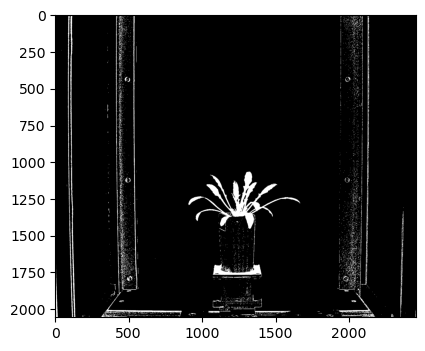

In [25]:
# Inputs:
#   gray_img = Grayscale (usually binary) image data.
#   ksize    = An odd integer that is used to build a ksize x ksize matrix using np.ones. Must be greater than 1 to 
#              have an effect
#   i        = An integer for number of iterations, i.e. the number of consecutive filtering passes.
s_dilated = pcv.dilate(gray_img = s_thresh, ksize = 2, i = 1)

## Fill in grainy noise

Fill in any spaces in the image smaller than a set size, to get rid of 'salt' noise that interferes with image analysis.

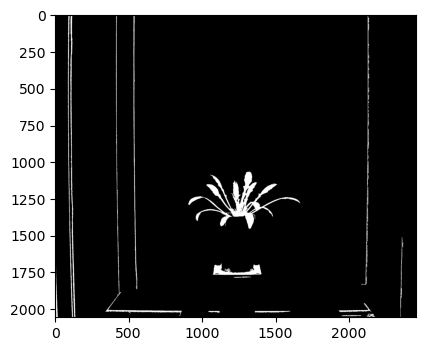

In [26]:
# Inputs:
#   bin_img = binary mask
#   size    = maximum size for objects to be filled in
s_fill = pcv.fill(bin_img = s_dilated, size = 500)

If filling in this grainy noise results in holes within the plant image, you can flood any holes that appear within the white image with white using pcv.fill_holes. However, this can cause problems, especially in plants with many branches that overlap, as this may create pockets of non-plant material that are now included in the mask.

## Crop mask to get rid of background noise

Some background noise can be removed by cropped the image to the plant material.

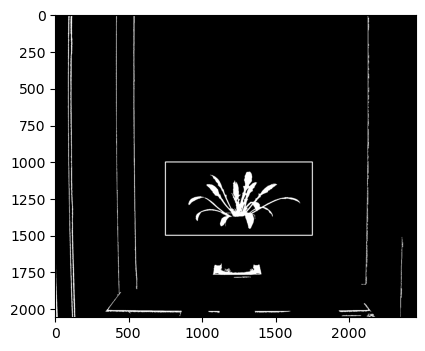

In [27]:
# Inputs:
#   img = binary mask
#   x = leftmost x position of desired area
#   y = topmost y position of desired area
#   h = height of desired area to be included in cropped image
#   w = width of desired area to be included in cropped image
cropped_mask = pcv.crop(img = s_fill, x = 750, y = 1000, h = 500, w = 1000)

## Issue 2: No good colorspace options

Sometimes, no colorspace will adequately distinguish plant material from background. In the example image, we were able to isolate the plant using dilate/fill, however there are cases when this may not work. When pot or soil interfers with the accuracey of the mask and cannot be thresholded using a colorspace, we can use multiple colorspaces to isolate plant material instead.

## Create first threshold

For this image, the original threshold was able to distinguish between the pot and plant fairly well. However, in some cases the plant and pot may be very similar shades, and since plant material overlaps with the pot, the fill function may not catch all of the pot as background. We can create a 'bad' threshold as an example for what it might look like if we could not isolate plant from pot in one colorspace.

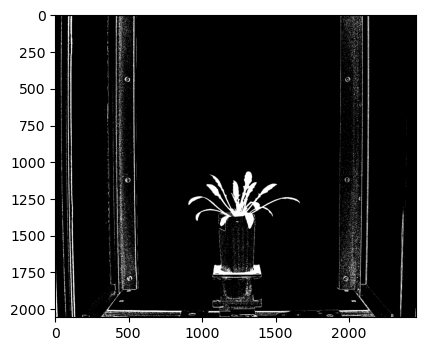

In [28]:
# Inputs:
#   gray_img    = Grayscale image data
#   threshold   = Threshold value (0-255)
#   max_value   = Value to apply above threshold (255 = white)
#   object_type = "light" or "dark" (default: "light"). If object is lighter than the background then standard 
#                 thresholding is done. If object is darker than the background then inverse thresholding is done.
s_bad = pcv.threshold.binary(gray_img=s, threshold=60, max_value=255, object_type='light')

## Create second threshold

In cases when the plant is difficult to isolate from the background and/or pot, we can utilize binary and/or functions to combine multiple masks into one. pcv.logical_and is useful for cases when different colorspaces pick up different areas of the plant, but neither can capture the entire plant. pcv.logical_or (shown below) is useful for cases when multiple colorspaces can capture the entire plant, but both have extensive noise from the background.

If one colorspace cannot distinguish between plant and background well enough, select a second colorspace that selects both for the plant material and picks up on different background images. 

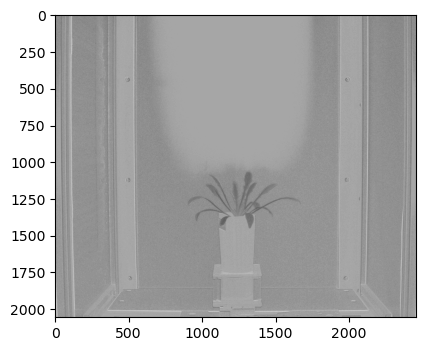

In [29]:
# Inputs:
#   rgb_img = original color image
#   channel = one of the colorspaces: 'l', 'a', or 'b'
a = pcv.rgb2gray_lab(rgb_img = img, channel='a')

## Visualize the distribution of grayscale values
A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the selection of a threshold value.

For this image, the large peak between 125-130 are from the darker background pixels. The smaller peak between 150-160 are the lighter seed pixels.

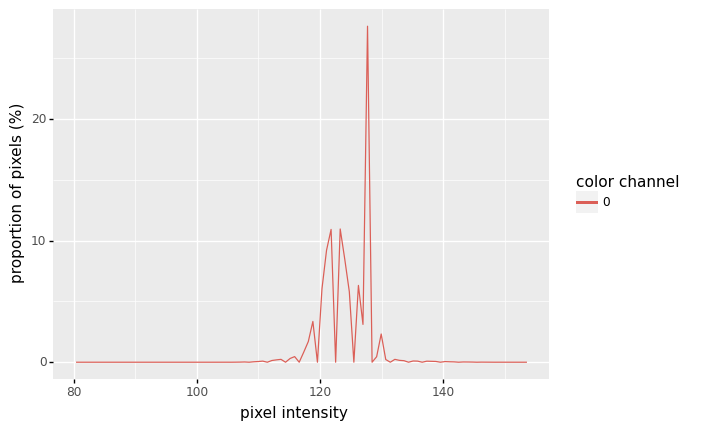

In [30]:
# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist2= pcv.visualize.histogram(img=a)

## Threshold the grayscale image

Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Using the histogram above, a threshold point between 110-120 will segment the plant and background peaks. Because the plant is lighter than the background in this image, use object_type="dark" to do a traditional threshold.

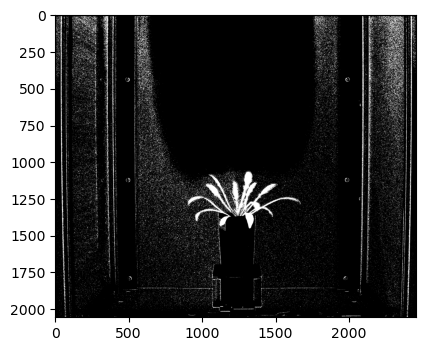

In [31]:
# Inputs:
#   gray_img    = Grayscale image data
#   threshold   = Threshold value (0-255)
#   max_value   = Value to apply above threshold (255 = white)
#   object_type = "light" or "dark" (default: "light"). If object is lighter than the background then standard 
#                 thresholding is done. If object is darker than the background then inverse thresholding is done.
a_thresh = pcv.threshold.binary(gray_img=a, threshold=119, max_value=255, object_type='dark')

## Combine the two masks

Since we now have two masks, both of which pick up on all the plant material, but have background noise in different locations, we can use the logical_and function to combine the two only if both images have white pixels in the same place.

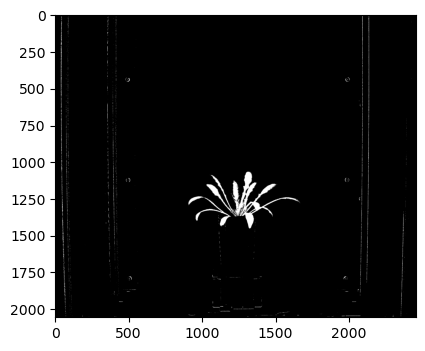

In [32]:
# Inputs:
#   bin_img1 = first binary mask
#   bin_img1 = second binary mask
mask = pcv.logical_and(bin_img1 = s_bad, bin_img2=a_thresh)

## Remove small background noise
Thresholding mostly labeled plant pixels white but also labeled small regions of the background white. The fill function removes "salt" noise from the background by filtering white regions by size.

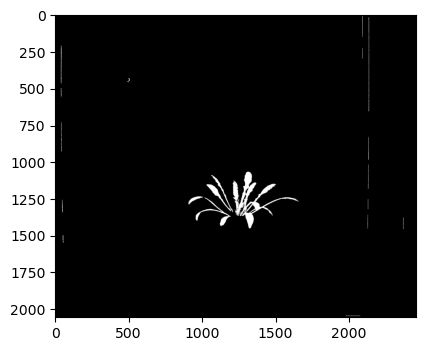

In [34]:
# Inputs:
#   bin_img = binary mask
#   size    = maximum size of white pixels to be filled in black
mask_fill = pcv.fill(bin_img = mask, size = 130)

## Crop mask

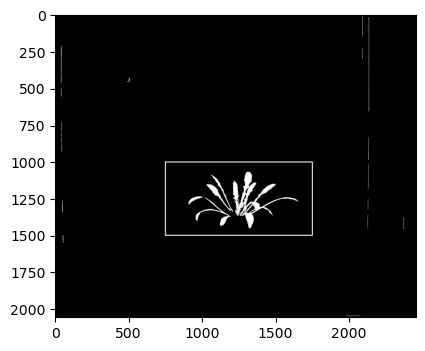

In [36]:
# Inputs:
#   img = binary mask
#   x = leftmost x position of desired area
#   y = topmost y position of desired area
#   h = height of desired area to be included in cropped image
#   w = width of desired area to be included in cropped image
cropped_mask = pcv.crop(img = mask_fill, x = 750, y = 1000, h = 500, w = 1000)